In [1]:
import numpy as np
import pandas as pd
%matplotlib notebook

In [18]:
n = str(2) #chiller number
df = pd.read_csv("data/Chiller"+n+"_full.csv")
df.index = pd.to_datetime(df['ts'])
df.drop('ts', axis=1, inplace=True)
df.head()

,ch1Watt,ch2Watt,ch3Watt,value1,value2,value3,value4,conflowRate,conflowSpeed,evaflowRate,evaflowSpeed
ts,,,,,,,,,,,
2017-05-01 00:00:00,325.0,0.0,324.0,18.580934,21.582337,23.633118,23.451539,0.0,0.0,0.0,0.0
2017-05-01 00:01:00,326.0,0.0,328.0,18.602295,21.539612,23.558351,23.398133,0.0,0.0,0.0,0.0
2017-05-01 00:02:00,327.0,0.0,324.0,18.495484,21.614379,23.483581,23.323363,0.0,0.0,0.0,0.0
2017-05-01 00:03:00,338.0,0.0,325.0,18.474123,21.571657,23.601076,23.205871,0.0,0.0,0.0,0.0
2017-05-01 00:04:00,334.0,0.0,328.0,18.559570,21.560973,23.536987,23.227236,0.0,0.0,0.0,0.0


In [19]:
df['deltaT12'] = df['value2']-df['value1']
df['deltaT34'] = df['value4']-df['value3']
df['totalWatt'] = df.apply(lambda row: row['ch1Watt']+row['ch2Watt']+row['ch3Watt'], axis=1)
df.drop(['ch1Watt', 'ch2Watt', 'ch3Watt'], inplace=True, axis=1)
df=df[['value1','value3','conflowRate','evaflowRate','deltaT12','deltaT34','totalWatt']]
df.head()

,value1,value3,conflowRate,evaflowRate,deltaT12,deltaT34,totalWatt
ts,,,,,,,
2017-05-01 00:00:00,18.580934,23.633118,0.0,0.0,3.001403,-0.181578,649.0
2017-05-01 00:01:00,18.602295,23.558351,0.0,0.0,2.937317,-0.160217,654.0
2017-05-01 00:02:00,18.495484,23.483581,0.0,0.0,3.118895,-0.160217,651.0
2017-05-01 00:03:00,18.474123,23.601076,0.0,0.0,3.097534,-0.395205,663.0
2017-05-01 00:04:00,18.559570,23.536987,0.0,0.0,3.001403,-0.309751,662.0


In [163]:
df['H']=df['deltaT12']*df['evaflowRate']
df.head()

,value1,value3,conflowRate,evaflowRate,deltaT12,deltaT34,totalWatt,H
ts,,,,,,,,
2017-05-01 00:00:00,18.580934,23.633118,0.0,0.0,3.001403,-0.181578,649.0,0.0
2017-05-01 00:01:00,18.602295,23.558351,0.0,0.0,2.937317,-0.160217,654.0,0.0
2017-05-01 00:02:00,18.495484,23.483581,0.0,0.0,3.118895,-0.160217,651.0,0.0
2017-05-01 00:03:00,18.474123,23.601076,0.0,0.0,3.097534,-0.395205,663.0,0.0
2017-05-01 00:04:00,18.559570,23.536987,0.0,0.0,3.001403,-0.309751,662.0,0.0


In [187]:
X = df[(df['evaflowRate']>125)&(df['totalWatt']>25000)][['value1', 'evaflowRate', 'deltaT12','H']].as_matrix()
y = df[(df['evaflowRate']>125)&(df['totalWatt']>25000)][['totalWatt']].as_matrix()

In [199]:
from sklearn import preprocessing
X_norm = preprocessing.scale(X)

In [213]:
dimension = X.shape[1]
window_size = 60
num_samples = len(X_norm)

In [214]:
# Data_align = np.zeros((window_size, num_samples - window_size + 1, dimension))
# for i in range(0, window_size):
#     Data_align[i] = X[i: num_samples - window_size + 1 + i]
# Full_Data = Data_align.transpose((1,0,2))
# Power = y[:num_samples - window_size + 1].reshape((-1,1))

In [215]:
import keras
from keras import layers
from keras.layers import Lambda, Activation,recurrent, Bidirectional, Dense, Flatten, Conv1D, Dropout, LSTM, GRU, concatenate, multiply, add, Reshape, MaxPooling1D, BatchNormalization
from keras.models import Model, load_model
import keras.backend as K

In [278]:
def mean_pred(y_true, y_pred):
    return K.mean(K.abs(y_pred - y_true)/(y_true))

In [305]:
inp = layers.Input(shape=(dimension,), dtype='float32')

In [306]:
# flatten = Flatten()(inp)
dense1 = Dense(500, activation='relu')(inp)
dense1 = Dropout(.1)(dense1)
dense2 = Dense(500, activation='relu')(dense1)
dense2 = Dropout(.1)(dense2)
dense3 = Dense(500, activation='relu')(dense2)
dense3 = Dropout(.1)(dense3)

In [307]:
output1 = Dense(1, activation='relu')(dense3)

In [308]:
model = Model([inp],[output1])
model.compile(optimizer='adam',
              loss='mean_absolute_error', metrics=[mean_pred])

In [309]:
test_inp = X[:63000]
test_out1 = y[:63000]
val_inp = X[63000:]
val_out1 = y[63000:]

In [310]:
model.fit([X], [y],
          epochs=15, validation_split=.1)
#           validation_data=([val_inp], [val_out1]))

Train on 63229 samples, validate on 7026 samples
Epoch 1/15
63229/63229 [==============================] - 23s 362us/step - loss: 12200.8346 - mean_pred: 0.0977 - val_loss: 8468.4298 - val_mean_pred: 0.0562
Epoch 2/15
63229/63229 [==============================] - 22s 354us/step - loss: 9907.9024 - mean_pred: 0.0792 - val_loss: 10404.6410 - val_mean_pred: 0.0665
Epoch 3/15
63229/63229 [==============================] - 23s 357us/step - loss: 9813.3661 - mean_pred: 0.0783 - val_loss: 18237.7410 - val_mean_pred: 0.1104
Epoch 4/15
63229/63229 [==============================] - 23s 370us/step - loss: 9626.0005 - mean_pred: 0.0770 - val_loss: 7974.2429 - val_mean_pred: 0.0537
Epoch 5/15
63229/63229 [==============================] - 23s 368us/step - loss: 9518.6891 - mean_pred: 0.0762 - val_loss: 8327.9658 - val_mean_pred: 0.0553
Epoch 6/15
63229/63229 [==============================] - 23s 357us/step - loss: 9452.4472 - mean_pred: 0.0757 - val_loss: 8504.2147 - val_mean_pred: 0.0562
Epoch 

KeyboardInterrupt: 

In [311]:
T1_min=np.array(df[(df['evaflowRate']>125)&(df['totalWatt']>25000)][['value1', 'evaflowRate']].describe().loc['min'])[0]
T1_max=np.array(df[(df['evaflowRate']>125)&(df['totalWatt']>25000)][['value1', 'evaflowRate']].describe().loc['max'])[0]
F_min=np.array(df[(df['evaflowRate']>125)&(df['totalWatt']>25000)][['value1', 'evaflowRate']].describe().loc['min'])[1]
F_max=np.array(df[(df['evaflowRate']>125)&(df['totalWatt']>25000)][['value1', 'evaflowRate']].describe().loc['max'])[1]
H_mean=np.array(df[(df['evaflowRate']>125)&(df['totalWatt']>25000)][['H']].describe().loc['mean'])[0]
df[(df['evaflowRate']>125)&(df['totalWatt']>25000)][['value1', 'evaflowRate','H']].describe()

,value1,evaflowRate,H
count,70255.000000,70255.000000,70255.000000
mean,8.584549,232.000196,638.730925
std,1.413967,3.363817,243.067214
min,0.000000,178.174408,-13454.889544
25%,7.686157,231.089134,539.247186
50%,8.401794,231.691666,684.866779
75%,9.309692,232.445282,752.142398
max,69.989324,509.306458,14201.987845


In [312]:
T1=np.arange(np.floor(T1_min), min(np.ceil(T1_max),30), 0.5)
F=np.arange(np.floor(F_min), min(np.ceil(F_max),250), 0.5)

In [313]:
#H is just deltaT12*F because optimizing ignores constants
H=H_mean
def COP(H,T1,F_full):
    n = len(T1)
    m = len(F_full)
    P_full=np.zeros((n,m))
    i=0
    for F in F_full:
        X=np.array([T1,F*np.ones(n),(H/F)*np.ones(n),H*np.ones(n)]).T
        P = model.predict(X).flatten()
        P_full[:,i]=P
        i+=1
    assert(P_full.shape == (n,m))
    return H/P_full,P_full
COP_T,P_T = COP(H,T1,F)

<IPython.core.display.Javascript object>


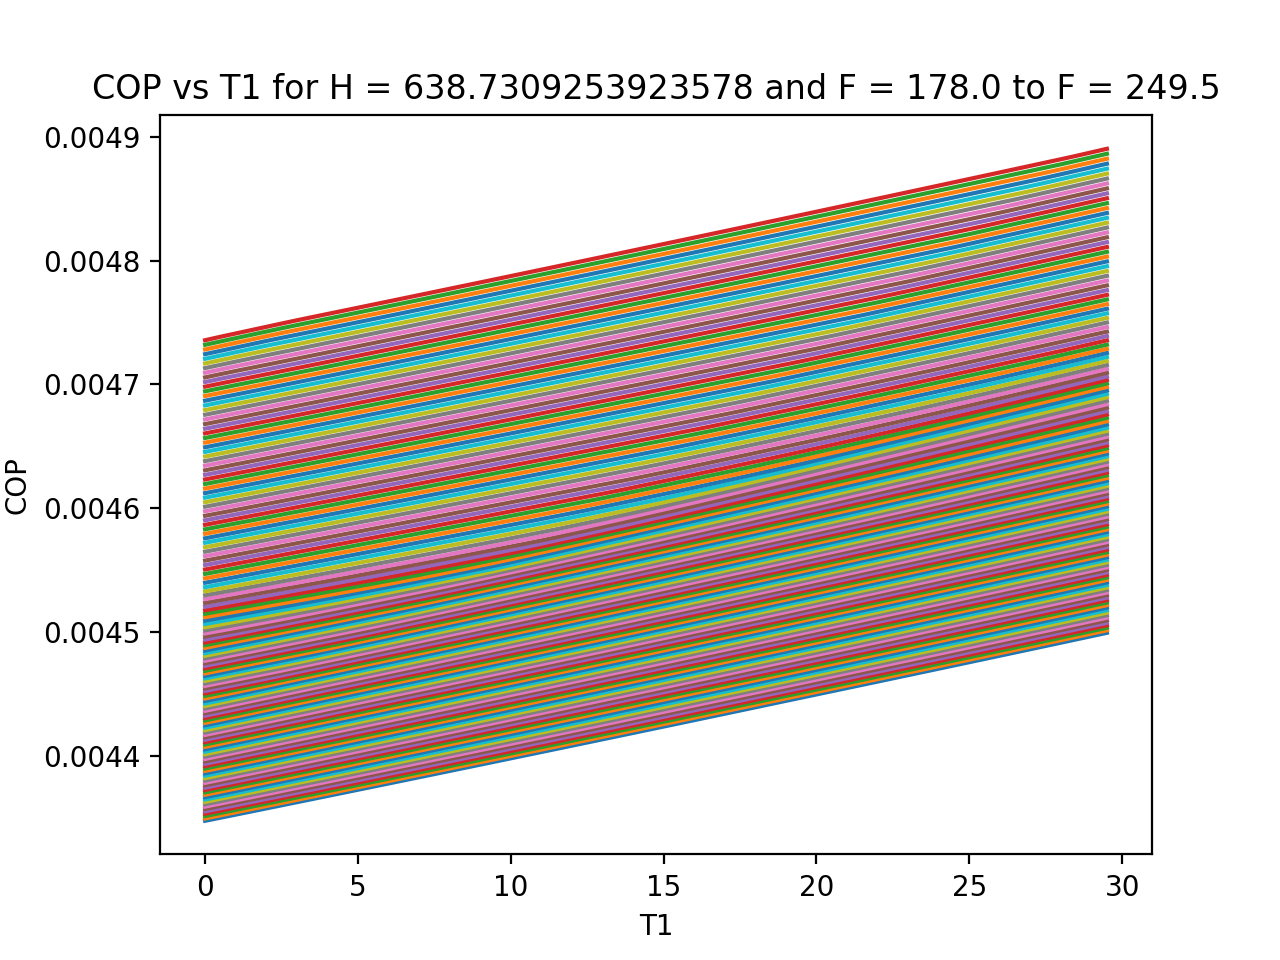

Text(0,0.5,'COP')

In [314]:
import matplotlib.pyplot as plt
%matplotlib notebook
plt.title('COP vs T1 for H = '+str(H)+' and F = '+str(F[int(np.ceil(len(F)/2))]))
plt.title('COP vs T1 for H = '+str(H)+' and F = '+str(F[0])+' to F = '+str(F[-1]))
#plt.axvline(x=T1[np.argmax(COP_T)], color='r')
#plt.plot(T1,COP_T[:,int(np.ceil(len(F)/2))])
plt.plot(T1,COP_T)
plt.xlabel('T1')
plt.ylabel('COP')

<IPython.core.display.Javascript object>


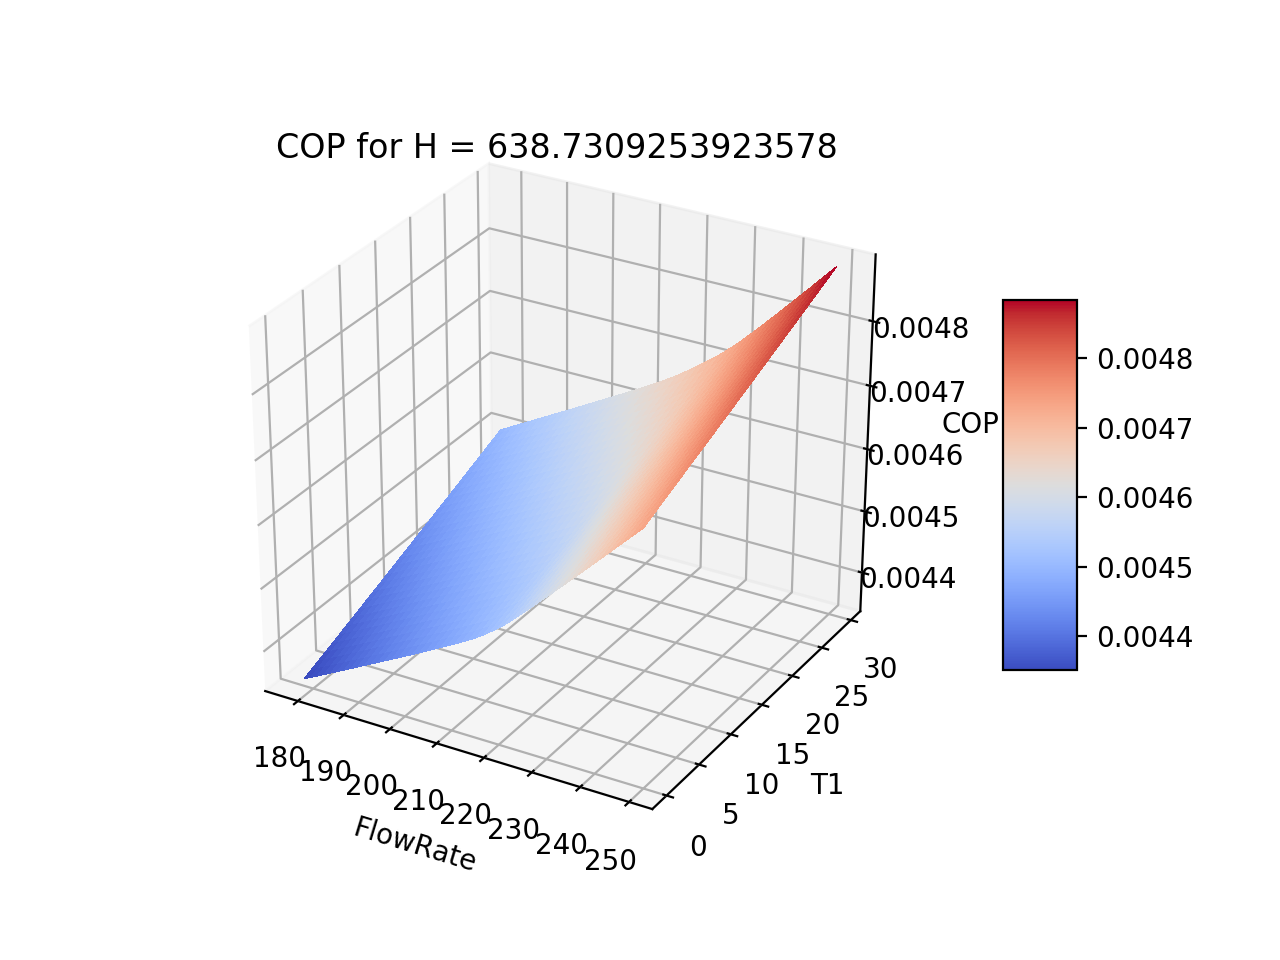

Text(0.5,0.92,'COP for H = 638.7309253923578')

In [316]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
F_full=np.ones((len(T1),1)).dot(F.reshape(1,len(F)))
T1_full=np.ones((len(F),1)).dot(T1.reshape(1,len(T1))).T
surf=ax.plot_surface(F_full, T1_full, COP_T,cmap=cm.coolwarm,linewidth=0, antialiased=False)
fig.colorbar(surf,shrink=0.5, aspect=5)
#surf=ax.plot_wireframe(F_full, T1_full, COP_T)
ax.set_xlabel('FlowRate')
ax.set_ylabel('T1')
ax.set_zlabel('COP')
ax.set_title('COP for H = '+str(H_mean))

In [13]:
df

,value1,value3,conflowRate,evaflowRate,deltaT12,deltaT34,totalWatt,H
ts,,,,,,,,
2017-05-01 00:00:00,18.580934,23.633118,0.0,0.000000,3.001403,-0.181578,649.0,0.000000
2017-05-01 00:01:00,18.602295,23.558351,0.0,0.000000,2.937317,-0.160217,654.0,0.000000
2017-05-01 00:02:00,18.495484,23.483581,0.0,0.000000,3.118895,-0.160217,651.0,0.000000
2017-05-01 00:03:00,18.474123,23.601076,0.0,0.000000,3.097534,-0.395205,663.0,0.000000
2017-05-01 00:04:00,18.559570,23.536987,0.0,0.000000,3.001403,-0.309751,662.0,0.000000
2017-05-01 00:05:00,18.602295,23.536987,0.0,0.000000,2.980042,-0.106812,667.0,0.000000
2017-05-01 00:06:00,18.559570,23.504945,0.0,0.000000,3.065493,-0.074770,703.0,0.000000
2017-05-01 00:07:00,18.602295,23.611757,0.0,0.000000,2.990723,-0.309754,708.0,0.000000
2017-05-01 00:08:00,18.677062,23.526306,0.0,0.000000,2.915956,-0.085447,722.0,0.000000


In [22]:
X

,value1,evaflowRate,deltaT12,H
ts,,,,
2017-05-08 00:47:00,18.110963,226.560425,1.046751,237.152371
2017-05-08 00:50:00,15.237732,234.721985,3.524780,827.343464
2017-05-08 00:51:00,14.757080,234.518555,3.717042,871.715427
2017-05-08 00:52:00,14.554138,234.278488,3.791809,888.339344
2017-05-08 00:53:00,14.287109,234.355446,3.845215,901.147085
2017-05-08 00:54:00,14.030760,234.424805,3.845215,901.413784
2017-05-08 00:55:00,13.710326,234.236176,3.866579,905.692734
2017-05-08 00:56:00,13.464661,234.477432,3.684998,864.048809
2017-05-08 00:57:00,13.016051,234.176315,3.770448,882.949674


In [89]:
H_mean

638.728065272812